# Representation Learning using Auto Encoders

In [3]:
import keras as K
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

2024-05-13 14:13:20.591558: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 14:13:20.591661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 14:13:20.758669: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
print("Keras version:", K.__version__)
print("TensorFlow version:", tf.__version__)

Keras version: 3.2.1
TensorFlow version: 2.15.0


In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.config.experimental.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

Num GPUs Available:  2
GPU is available


In [67]:
def log_reg(train_images, train_labels, test_images, test_labels):
    # set up classifier model
    classifier_input = K.layers.Input(shape=(64,))
    classifier_output = K.layers.Dense(10, activation='softmax')(classifier_input)
    classifier = K.Model(classifier_input, classifier_output)
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # early stopping
    early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)

    # training the classifier
    classifier.fit(train_images, train_labels, epochs=50, batch_size=128, validation_split=0.2, verbose=0, callbacks=[early_stopping])

    # classifier's evaluation
    test_loss, test_accuracy = classifier.evaluate(test_images, test_labels)
    print(f'Test accuracy: {test_accuracy}, Test loss: {test_loss}')
    
def convergence(model, max_iter=100, n_img=10):
    fig, axes = plt.subplots(1, n_img, figsize=(20, 2)) 

    for i in range(n_img):
        noise_image = np.random.normal(loc=0, scale=1, size=(1, 784))
        noise_image = np.clip(noise_image, 0., 1.)

        for _ in range(max_iter):
            noise_image = model.predict(noise_image, verbose=0)

        # Plot the denoised image
        ax = axes[i]
        ax.imshow(noise_image.reshape(28, 28), cmap='gray')
        ax.set_title(f"Image {i+1}")
        ax.axis('off')  # Hide axes ticks

    plt.show()



## Denoising Auto Encoder
In the following we are going to dive into DAEs to learn hidden representations of the MNIST dataset.

At first we will try with an auto-encoder of two layers of very small dimensions, that will get trained altogether. After that we are going to implement Greedy Unsupervised Layerwise Pretraining which will be used to train the same two layers used in the first instance, but once at a time –i.e. we train one layer to predict the noised data coming from the preceding layer (where the first layer will get the data as input). Afterwards, we'll also fine-tune the autoencoder to see if any improvement occurs.

### Data preprocessing

In [6]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# reshape images to 1D
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images = train_images.reshape((len(train_images), 784))
test_images = test_images.reshape((len(test_images), 784))

# add noise to images
noise_factor = 0.5
x_train_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape) 
x_test_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

train_labels = K.utils.to_categorical(train_labels, 10)
test_labels = K.utils.to_categorical(test_labels, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 2-layers Auto-Encoder

In [59]:
# setting up the model
input_img = K.layers.Input(shape=(784,))
# encoder
encoded = K.layers.Dense(128, activation='relu')(input_img)
encoded = K.layers.Dense(64, activation='relu')(encoded)
# decoder
decoded = K.layers.Dense(128, activation='relu')(encoded)
decoded = K.layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = K.Model(input_img, decoded)
encoder = K.Model(input_img, encoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# early stopping
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)

# autoencoder's training
autoencoder.fit(x_train_noisy, train_images, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, verbose=0, callbacks=[early_stopping])

W0000 00:00:1715611788.375487     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715611789.393524     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715611789.884733     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715611790.168511     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Restoring model weights from the end of the best epoch: 47.


#### Classification score, reconstruction error and manifold convergence

In [66]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(x_train_noisy, verbose=0)
encoded_test_images = encoder.predict(x_test_noisy, verbose=0)

log_reg(encoded_train_images, train_labels, encoded_test_images, test_labels)

Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 15.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8322 - loss: 0.5368
Test accuracy: 0.857699990272522, Test loss: 0.4691825807094574


In [63]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(x_test_noisy, verbose=0), test_images).numpy()
print(f'Reconstruction error: {reconstruction_error}')

W0000 00:00:1715611854.950843     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Reconstruction error: 0.016656259074807167


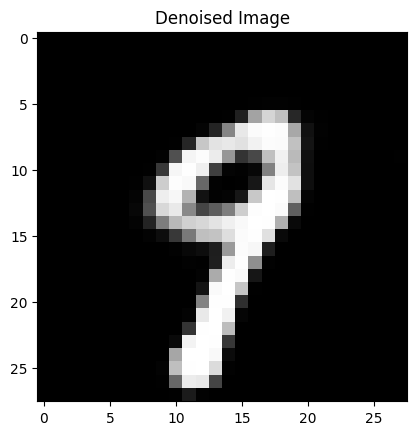

In [69]:
convergence(autoencoder)

### Greedy Unsupervised Layerwise Pretraining
As anticipated above, we are now implementing the GULP strategy to train deep autoencoders (each one composed of a single layer). In this case, given the simpplicity of the dataset we are going to use just two autoencoders (one with a layer of 256 units and one with a layer of 128, in order to match the structure of the previous built autoencoder).

In [53]:
# define the autoencoder structure
def create_autoencoder(input_size, encoding_dim):
    input_layer = K.layers.Input(shape=(input_size,))
    encoded = K.layers.Dense(encoding_dim, activation='relu')(input_layer)
    decoded = K.layers.Dense(input_size, activation='sigmoid')(encoded)
    autoencoder = K.Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

# layerwise pretraining
first_autoencoder = create_autoencoder(784, 256)
# early stopping
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
first_autoencoder.fit(x_train_noisy, x_train_noisy, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, callbacks=[early_stopping], verbose=0)

# get the encoder
first_encoder = K.Model(first_autoencoder.input, first_autoencoder.layers[1].output)
first_encoded_train = first_encoder.predict(x_train_noisy, verbose=0)

# adding noise to the hidden representation of the first autoencoder
first_encoded_train_noised = first_encoded_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=first_encoded_train.shape)
first_encoded_train_noised = np.clip(first_encoded_train_noised, 0., 1.)

second_autoencoder = create_autoencoder(256, 128)
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
second_autoencoder.fit(first_encoded_train_noised, first_encoded_train, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, callbacks=[early_stopping], verbose=0)

# stacking up the full autoencoder
input_img = K.layers.Input(shape=(784,))
first_encoded = first_autoencoder.layers[1](input_img)
second_encoded = second_autoencoder.layers[1](first_encoded)
second_decoded = second_autoencoder.layers[2](second_encoded)
first_decoded = first_autoencoder.layers[2](second_decoded)

autoencoder = K.Model(input_img, first_decoded)
encoder = K.Model(input_img, second_encoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 28.
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [54]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(x_train_noisy, verbose=0)
encoded_test_images = encoder.predict(x_test_noisy, verbose=0)

log_reg(encoded_train_images, train_labels, encoded_test_images, test_labels)

Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 38.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6045 - loss: 1.1919
Test accuracy: 0.641700029373169, Test loss: 1.0979584455490112


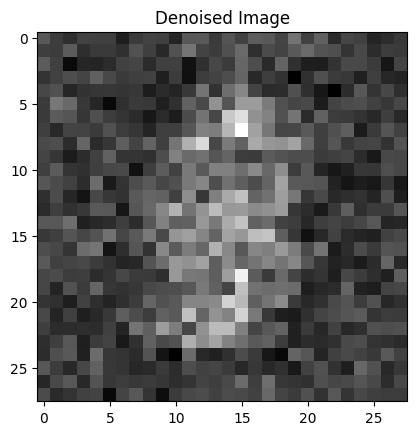

In [55]:
convergence(autoencoder)

The pre-training did not end up with a significant representation of the data, though as we can see from the image, it seems to be getting a grasp on where most digits are located –i.e. in the center of the image.

To improve the perfomance, we are now fine-tuning the model, precisely we are let the model train for some other epochs until it starts to overfit (using early stopping to prevent it). Notice that the weights do not reset, rather they are set from the pre-training.

In [56]:
# fine-tuning the full autoencoder
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
autoencoder.fit(x_train_noisy, train_images, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, callbacks=[early_stopping], verbose=0)

Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 40.


In [57]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(x_train_noisy, verbose=0)
encoded_test_images = encoder.predict(x_test_noisy, verbose=0)

log_reg(encoded_train_images, train_labels, encoded_test_images, test_labels)

Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8473 - loss: 0.5020
Test accuracy: 0.8687999844551086, Test loss: 0.4308898448944092


The accuracy did improve significantly w.r.t. the pre-trained model, but just a little in comparison to the previous auto-encoder, the one that has been trained without GULP.

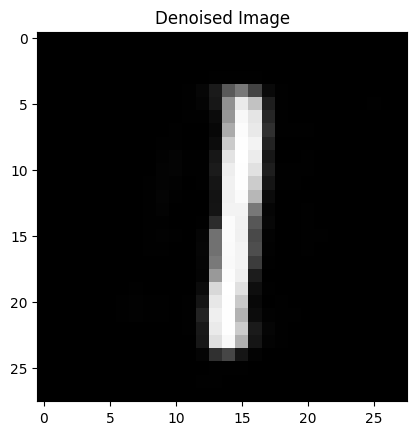

In [58]:
convergence(autoencoder)

Once again, the model seems to have learned a representation of the data as the random noise image converges to some digits.

## Using a U-Shaped CNN as encoder-decoder structure
Since we are dealing with images, we will now see whether using a U-Shaped CNN gives us any conspicuous advantage. We will restrict ourselves to just explore a simple structure of two convolutions/deconvolutions (where we will use maxpooling to downsample and a strided deconvolution to upsample).

In [98]:
(train_images_2D, _), (test_images_2D, _) = mnist.load_data()

# reshape images to 1D
train_images_2D = train_images_2D.astype('float32') / 255.
test_images_2D = test_images_2D.astype('float32') / 255.

# Normalize and reshape the data
train_images_2D = np.reshape(train_images_2D, (len(train_images_2D), 28, 28, 1))
test_images_2D = np.reshape(test_images_2D, (len(test_images_2D), 28, 28, 1))

# Create noisy data
x_train_noisy_2D = train_images_2D + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images_2D.shape) 
x_test_noisy_2D = test_images_2D + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images_2D.shape)

x_train_noisy_2D = np.clip(x_train_noisy_2D, 0., 1.)
x_test_noisy_2D = np.clip(x_test_noisy_2D, 0., 1.)

# Build the autoencoder model
input_img = K.layers.Input(shape=(28, 28, 1))

# Encoder
x = K.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = K.layers.MaxPooling2D((2, 2), padding='same')(x)
x = K.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = K.layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = K.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = K.layers.UpSampling2D((2, 2))(x)
x = K.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = K.layers.UpSampling2D((2, 2))(x)
decoded = K.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = K.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
autoencoder.fit(x_train_noisy_2D, train_images_2D, epochs=50, batch_size=128, shuffle=True, validation_split=0.2, callbacks=[early_stopping], verbose=0)

Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 45.


In [99]:
# Extract the encoder part from the trained autoencoder
autoencoder_input = K.layers.Input(shape=(28, 28, 1))
x = autoencoder.layers[1](autoencoder_input)  # First Conv2D layer
x = autoencoder.layers[2](x)  # First MaxPooling2D layer
x = autoencoder.layers[3](x)  # Second Conv2D layer
encoded_output = autoencoder.layers[4](x)  # Second MaxPooling2D layer

# Define the classifier
flatten = K.layers.Flatten()(encoded_output)
dense = K.layers.Dense(128, activation='relu')(flatten)
classifier_output = K.layers.Dense(10, activation='softmax')(dense)
classifier_model = K.Model(autoencoder_input, classifier_output)

# Compile and train the classifier
classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier_model.fit(x_train_noisy_2D, train_labels, epochs=30, batch_size=256, validation_split=0.2, verbose=0)

# Evaluate the classifier
test_loss, test_accuracy = classifier_model.evaluate(x_test_noisy_2D, test_labels, verbose=0)
print(f'Test accuracy: {test_accuracy}, Test loss: {test_loss}')

W0000 00:00:1715614293.379727     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715614295.186868     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715614295.882738     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715614296.894661     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715614322.811127     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test accuracy: 0.9682999849319458, Test loss: 0.1974364072084427


W0000 00:00:1715614323.801149     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


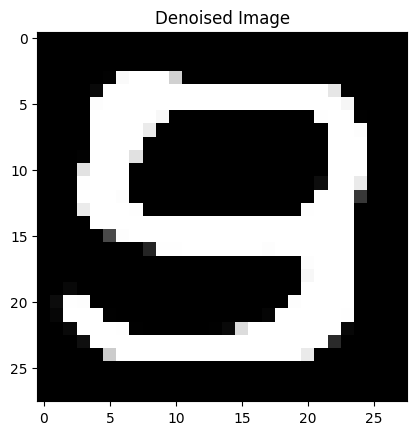

In [100]:
# Generate a noise image and iteratively denoise it
noise_image = np.random.normal(loc=0.5, scale=0.5, size=(1, 28, 28, 1))
noise_image = np.clip(noise_image, 0., 1.)

for i in range(100):  # Number of iterations can be adjusted
    noise_image = autoencoder.predict(noise_image, verbose=0)

# Display the final output
plt.imshow(noise_image.reshape(28, 28), cmap='gray')
plt.title("Denoised Image")
plt.show()


The accuracy surely gets better than the previous models, but the reconstructions are the weirdest looking ones so far.